### **Перед тем как начать.**

Для корректного отображения некоторых материалов вам необходимо установить на свою машину модуль `ipympl`\
и перезагрузить этот ноутбук (файл, не компьютер).

In [ ]:
# %pip install ipympl

# !conda install ipympl

Теперь убедимся, что все модули, которые нам нужны, установлены и работают как надо.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
from scipy.optimize import minimize

from astropy.io import fits

%matplotlib widget

Наконец, убедимся, что импорт функций и класса из самописного модуля тоже\
работает корректно.

In [ ]:
from spec import phabs, powerlaw, zphabs, zpowerlaw, Observation

Если все блоки с импортами выполнились нормально, то можно приступать\
к выполнению задания.

Если где-то вывалились ошибки, позовите преподавателя и разберитесь,\
в чем дело.

### **Кто такой этот ваш спектральный анализ.**

На прошлом занятии, и еще несколько раз до этого мы обсуждали, что\
рентгеновские (и многие другие) телескопы регистрируют помимо прочего\
еще и энергию прилетающих фотонов.

На самом деле, этот процесс предполагает довольно много технической подготовки,\
с которой мы сегодня и попробуем разобраться.

**На этом занятии вы**:
1. Разберетесь, из каких технических частей состоит анализ\
спектров в рентгеновском диапазоне спектра.
2. Оцените (неправильным образом) спектр вспышки на звезде.
3. Фитируете полученный спектр простой моделью.
4. Самостоятельно построите спектр рентгеновского излучения\
от активного ядра галактики.

### **Часть 1. Технические аспекты анализа данных.**

В реальной работе для фитирования спектров обычно используется\
сторонний софт, такой как [XSPEC](https://heasarc.gsfc.nasa.gov/xanadu/xspec/).

Для его установки нужно много подготовительной работы, включая\
установки Linux и софта для обработки данных рентгеновских телескопов [HEASOFT](https://heasarc.gsfc.nasa.gov/docs/software/heasoft/).

В рамках этого занятия мы будем использовать не настоящий софт,\
а маленький самописный модуль, написанный на Python.

Этот модуль должен лежать в одной папке с этим ноутбуком и называться [`spec.py`](spec.py).

Главные объекты, которые мы оттуда достанем:
1. Класс `Observation`, который нужен для работы с данными спектров.
2. Функции типа `phabs, powerlaw` и т.д., которые используются при фитировании

In [ ]:
from spec import Observation, phabs, powerlaw, zphabs, zpowerlaw

Для иллюстрации того, что происходит, используем реальные данные наблюдений\
рентгеновского телескопа [XMM-Newton](https://en.wikipedia.org/wiki/XMM-Newton).

В данном случае мы будем смотреть на спектр звезды G-класса, на которой\
произошла очень мощная вспышка.

Для спектрального анализа нам, как правило, необходимо 4 вещи:
1. Спектр наблюдения.
2. Спектр фона.
3. Функция отклика детектора (Redistribution Matrix File).
4. Эффективная площадь детектора (Auxilary Response File).

Все они передаются в софт для анализа спектра перед началом работы с ним.

In [ ]:
obs = Observation(
    src_spec = './data/flare/src_spec.fits',
    arf = './data/flare/spec.arf',
    rmf = './data/flare/spec.rmf',
    bkg_spec = './data/flare/bkg_spec.fits'
)

Спектры и от источника, и фона хранятся в виде числа отсчетов на канал по энергии и извлекаются из\
соответствующих частей наблюдения (источник внутри зеленого круга, фон в красном кольце):

> *__Задание 1.1__*\
Постройте график зависимости числа отсчетов от номера канала для источника и для фона\
в одних осях. Сравните их между собой.\
*Подсказка*:\
Спектр источника хранится в виде `recarray` в атрибуте `obs.src`\
Спектр фона хранится в виде `recarray` в атрибуте `obs.bkg`

![./data/figures/flare_img.png](./data/figures/flare_img.png)

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

Если все сделано правильно, то вы должны увидеть одно загадочное\
несоответствие того, что мы ожидаем с тем, что мы получили.

> *__Задание 1.2__*\
Предложите , чем это несоответствие вызвано.

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

*Дело в том, что время и площадь неба, с которой мы собираем спектры\
сигнала и фона могут отличаться, причем часто именно фон\
собирается с бОльшего участка неба для наилучшего его описания.*

*Именно поэтому для анализа спектра источника за вычетом фона необходимо\
сначала отнормировать числа отсчетов на фактор $\rm (Area \cdot Exposure)$*

</details>
</p>

В нашем случае для корректировки этих двух факторов достаточно умножить\
спектр `bkg` на коэффициент `obs.bkg_to_src`.

> *__Задание 1.3__*\
Постройте тот же график, что и выше, но с учетом корректирочного коэффициента.

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

Далее нам необходимо преобразовать отсчеты в разных каналах в энергию.\
Для этого используется матрица RMF.

Эта матрица показывает вероятность, что фотон с энергией E попадет в канал N.

In [ ]:
obs.plot_rmf()

В настоящем анализе данных все маленькие эффекты, которые вы видите выше\
учитываются при анализе. Для нашего анализа мы попытаемся сделать обратное\
преобразование из каналов в энергии, воспользовавшись аппроксимацией главной\
линии в графике выше.

Наконец, для полноценного отображения спектров их необходимо нормировать\
на собирающую площадь, с которой фотоны попадают на детектор, а также\
на эффективность поглощения этих фотонов в результате фотоэффекта.

Произведение этих двух факторов называется эффективной площадью,\
и хранится в ARF-файле.

In [ ]:
obs.plot_arf()

Еще одним важным аспектом анализа реальных данных является необходимость\
хорошей выборки (хорошей статистики) наблюдения для получения значимых результатов.

Если в вашем канале по энергии всего 1 фотон, то невозможно только по этому каналу\
сделать хоть сколь-нибудь значительные выводы о спектре.

В этой связи для получения значительной статистики смежные каналы объединяют\
в один отрезок по энергии и воспринимают его как одно целое, смешивая все отсчеты\
в одну кучу.

В рамках написанного кода это реализовано при помощи функции `obs.group_bin(num_counts)`,\
которая объединяет каналы до тех пор, пока в них не окажется не менее `num_counts` отсчетов.

In [ ]:
obs.group_bin(25)

После выполнения этой функции в вашем объекте `obs` появляются новые атрибуты:
- `obs.en` -- массив центров отрезков по энергиям, на которые мы разделили спектр
- `obs.en_step` -- массив полуширин каждого отрезка
- `obs.group_src` -- массив числа отсчетов источника в каждом отрезке
- `obs.group_bkg` -- массив числа отсчетов фона в каждом отрезке
- `obs.group_arf` -- средняя эффективная площадь в каждом отрезке

> *__Задание 2__*\
Постройте график числа отсчетов источника от энергии.\
На графике укажите статистические ошибки этого числа отсчетов,
равные корню из числа отсчетов.\
Также укажите ширину отрезков по энергии.

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

### **_Часть 2. Неправильные вещи с (условно) правильными результатами._**

После разговоров выше у нас в руках есть все компоненты для того, чтобы провести\
«прямое» фитирование:
возьмем модель, умножим ее на эффективную площадь и экспозицию, свернем с\
функцией отклика детектора, добавим к этому фон, соберем в группы по каналам\
и получим ожидаемое число отсчетов.

Это число отсчетов можно напрямую сравнивать с количеством отсчетов, которое мы видим\
в реальности, и на основании этого подгонять наши модели.

В рамках этого практикума этот процесс слишком трудоемкий (хотя вы имеете полное право\
попробовать его написать в рамках дополнительного задания), поэтому вместо этого мы проделаем\
«обратное» и **неправильное** фитирование:\
Возьмем настоящие данные, сгруппируем их, переведем из каналов в энергии, разделим на\
экспозицию и эффективную площадь и уже это сравним с нашей моделью.

**Я еще раз обращаю ваше внимание, что это не то, как фитирование работает на самом деле.**

> **_Задание 3_**\
Постройте спектр источника (с вычтенным фоном), рассчитанный на единицу площади, за 1 секунду,\
нормированный на ширину отрезка по энергии.\
Сравните полученный график с примером из переменной `data`.

*__Подсказки.__*
1. `obs` также содержит атрибут `obs.exposure`, который отражает экспозицию наблюдения.
2. Вы можете поиграть с настройками разделения спектра на отрезки (бинирования).
3. Для вычисления ошибок можете пренебречь всеми ошибками, кроме статистической ошибки\
определения числа детектированных событий, которые распределены с [Пуассоновским распределением](https://en.wikipedia.org/wiki/Poisson_distribution).

In [3]:
data = pd.read_csv('./data/flare.txt', sep=' ', index_col=None)

In [ ]:
plt.close()

plt.errorbar(data.en, data.cnts, data.err, data.en_half, fmt='.')

# ================================================================
# МЕСТО ДЛЯ ВАШЕГО КОДА




# ================================================================
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy, keV')
plt.ylabel(r'$\rm cnts \times s^{-1} \times cm^{-2} \times keV^{-1}$')

plt.show()

Если полученные графики описывают одинаковую кривую, значит вы все сделали верно,\
и можно переходить к следующему этапу -- фитированию.

### **_Часть 3. Фитирование._**

Теперь, когда мы знаем, как получить (условно) верное и не зависящее\
от параметров телескопа представление спектра, мы можем сравнивать его с\
нашими моделями напрямую.

В рамках этого практикума мы не будем глубоко погружаться в физические модели,\
поэтому для иллюстрации процесса ограничимся фитированием\
[простым степенным законом](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node220.html) с [поглощением межзвездной среды](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelPhabs.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd

from astropy.io import fits

from matplotlib.colors import SymLogNorm

from spec import Observation, phabs, powerlaw, zphabs, zpowerlaw

%matplotlib widget

> **_Задание 4.0_**\
Для удобства дальнейшей работы запишите параметры найденного\
выше спектра в следующем виде:
- `en` - значения центров бинов по энергии
- `en_step` - значения ширин бинов по энергии
- `cnts` - нормированные отсчеты, которые вы получили из своих данных выше
- `err` - значение ошибок этих нормированных отсчетов

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

Попробуем описать спектр излучения этой вспышки простым степенным законом (`powerlaw`) с двумя параметрами:\
$\Gamma$ - коэфициент наклона степенного закона.
norm - нормировка степенного закона.

Кроме того, мы добавим фиксированный коэффициент умножения модели, которая учитывает поглощение\
рентгеновского излучения в результате прохождения через межзвездную среду (`phabs`).\
Эта модель принимает один параметр -- «толщину» этой среды в единицах $\rm atom / cm^{2}$.

Из ранее проведенных [исследований](https://arxiv.org/abs/1610.06175) плотности межзвездной среды, мы\
знаем значение этого параметра, поэтому всего парамертров модели у нас два:

Теперь попробуем вручную подобрать эти параметры для хорошего соответствия данным.

> **_Задание 4.1_**\
Подберите параметры модели так, чтобы кривая\
хорошо ложилась на данные.\
Не обращайте внимания на код, там ничего полезного не происходит.\
Смотрите на картинку и меняйте параметры модели там же.

0

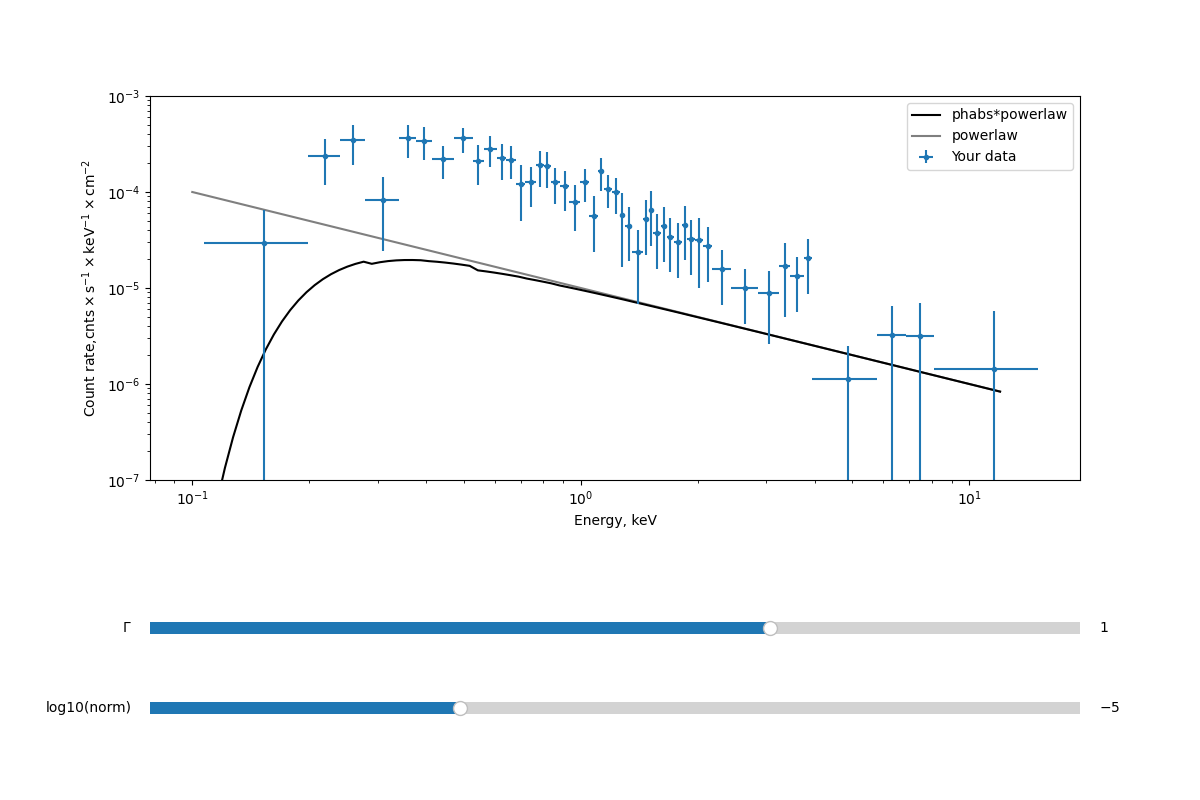

In [4]:
en_model = np.geomspace(0.1, 12, 100)

init_norm = np.log10(1e-5)
init_index = 1.0
init_nh = 1.91E-2

plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
line_absorbed, = ax.plot(en_model, phabs(en_model, init_nh) * powerlaw(en_model, init_index, 10**init_norm), color='black', label='phabs*powerlaw')
line, = ax.plot(en_model, powerlaw(en_model, init_index, 10**init_norm), color='black', alpha=0.5, label='powerlaw')

# ЕСЛИ ВЫ НАЗВАЛИ СВОИ ПЕРЕМЕННЫЕ КАК-ТО ИНАЧЕ, ВПИШИТЕ СЮДА
sc = ax.errorbar(data.en, data.cnts, data.err, data.en_half, fmt='.', label='Your data') 


ax.set_ylim(1e-7, 1e-3)
ax.set_xlabel('Energy, keV')
ax.set_ylabel(r'Count rate,$\rm cnts \times s^{-1} \times keV^{-1} \times cm^{-2}$')
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()

fig.subplots_adjust(left=0.125, bottom=0.4)
ax_norm = fig.add_axes([0.125, 0.1, 0.775, 0.03])
ax_index   = fig.add_axes([0.125, 0.2, 0.775, 0.03])

norm_slider = Slider(
    ax=ax_norm,
    label='log10(norm)',
    valmin=-6,
    valmax=-3,
    valinit=init_norm
)

index_slider = Slider(
    ax=ax_index,
    label=r'$\Gamma$',
    valmin=-3,
    valmax=3,
    valinit=init_index
)

def update(val):
    line_absorbed.set_ydata(phabs(en_model, init_nh)*powerlaw(en_model, index_slider.val, 10**(norm_slider.val)))
    line.set_ydata(powerlaw(en_model, index_slider.val, 10**(norm_slider.val)))
    fig.canvas.draw_idle()

norm_slider.on_changed(update)
index_slider.on_changed(update)

Как вы можете заметить, вариантов для описания данного спектра оказывается довольно много,\
и определить на глаз, какой из них лучше описывает данные, не представляется возможным.

Для определения статистически наилучшего набора параметров модели снова используют уже знакомое\
нам значение $\chi^{2}$, которое отображает, насколько хорошо данные фитируются нашей моделью.

**Чтобы реализовать этот метод, необходимо выполнить следующие шаги**:
1. Написать функцию, которая принимает параметры модели и возвращает значения модели в наших точках.
2. Написать функцию, которая считает значение $\chi^{2}$ для заданной модели и наших данных.
3. Использовать алгоритм минимизации, который итерационно найдет параметры с наименьшим значением статистики.

> Задание 4.2\
Выше для фитирования нашего спектра использовались две функции: `phabs` и `powerlaw`.\
Разберитесь, какие параметры принимает каждая из функций, что она возвращает,\
и напишите функцию, которая принимает параметры двух моделей и возвращает\
результирующую модель `phabs * powerlaw` в точках массива `en`:

```python
def my_model(en, <parameters>):
    <your code>
    return <values of model in en array>
```

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

Теперь, когда у нас есть значения данных в каждой точке и значение модели\
в каждой точке, мы можем для всей модели вычислить значение $\chi^2$\
по следующей формуле:

$\rm \chi^2 = \sum_{i=1}^n\cfrac{(data_i-model_i)^2}{err_i}$,

`data` - массив значений спектра из данных,\
`model` - массив значений спектра по модели,\
`err` - массив значений ошибок на спектр из данных.

Обратите внимание, что использовать эту формулу можно только в случае, если\
в каждом бине по энергии содержится достаточно большое (~20 и больше) отсчетов.\
В противном случае результаты минимизации могут быть значительно искажены.

> Задание 4.3\
Пользуясь формулой выше, напишите функцию, которая принимает фитируемые\
параметры модели в виде одного массива, и возвращает значения $\chi^2$.

Учтите, какую модель мы хотим использовать: мы знаем значение `nH` для `phabs`\
и фитируем только параметры модели `powerlaw`.

`nH` фиксировано на значении 1.91e-2.

```python

def chi_square(x, *args):
    <your code>
    return <chi_square>
```
`x` - массив параметров модели `my_model`,\
`args` - tuple прочих аргументов, которые не нужно фитировать.

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

Теперь только что написанную функцию можно передать в функцию `scipy` для\
итерационной минимизации [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

Она принимает аргументы следующим образом:
```python
minimize(fun, x0, args=(), ...) -> res (.x, .success, .message)
```

Принимает:\
`fun` - функция с аргументами (x, *args), результат которой мы хотим минимизировать,
`x0` - набор начального приближения параметров модели, взятый из оценки на глаз,
`args` - tuple прочих параметров функции, которые мы хотим передать, но не варьировать.

Возвращает:\
`res` - класс с атрибутами:\
`res.x` - набор параметров модели - результат минимизации,\
`res.success` - статус успешности выполнения минимизации,\
`res.message` - более подробное сообщение о статусе минимизации.

> Задание 4.4\
Используйте функцию `minimize` на наших данных, сравните полученные результаты
со своей оценкой на глаз.\
Нарисуйте на одном графике: данные, свою начальную модель и найденную оптимальную.

> Задание 4.5 (дополнительное)\
Добавьте к графику выше вторые оси снизу и нарисуйте там график `(data - model) / err`

In [ ]:
from scipy.optimize import minimize

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

### **_Часть 4. Вольное плавание._**

Весь этот раздел предназначен для тех, кто справился с предыдущими и хочет поделать что-то еще.\
Задание этого раздела -- самостоятельно провести фитирование второго спектра в этих данных при помощи\
моделей `zphabs` и `zpowerlaw`, которые учитывают красное смещение объекта наблюдения, в нашем случае,\
активного ядра галактики (сверхмассивной черной дыры с аккрецией) на [красном смещении](https://en.wikipedia.org/wiki/Redshift) z ~ 0.8.

**В рамках этого практикума вам предлагается самостоятельно (но не значит, что без подсказок)**:
1. найти в файлах этого практикума нужные файлы и подгрузить спектр нашего объекта,
2. вытащить из этих данных спектр,
3. подготовить его для фитирования,
4. подготовить функции для фитирования,
5. фитировать спектр моделью `phabs(nH=7e-3) * zphabs(nH = ?, z = ?) * zpowerlaw(Gamma = ?, norm = ?, z = ?)`
6. Нарисовать график полученного фита с нашими данными.

В качестве предисловия отметим только, что модель, которой мы будем фитировать наш спектр, учитывает три вещи:
1. поглощение межзвездной среды в нашей Галактике на луче зрения от АЯГа до телескопа,
2. поглощение излучения веществом непосредственно вокруг АЯГа из-за плотного пылевого облака (тора?) вокруг него,
3. спектр излучения самого АЯГа, который мы в данном случае описываем простым степенным законом.

2 и 3 компоненты находятся на очень больших расстояниях от нас, поэтому излучение, от них приходящее, необходимо,\
преобразовывать с учетом красного смещения, эффекта сдвига спектра в сторону низких частот (в сторону красного цвета).\
Этот эффект для компонент будет одинаковый, поскольку и вещество вокруг АЯГа и сам АЯГ находятся на одинаковом расстоянии.

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА